In [17]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import ppscore as pps
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


'\ndef reduce_memory_usage(df):\n    """ The function will reduce memory of dataframe\n    Note: Apply this function after removing missing value"""\n    intial_memory = df.memory_usage().sum()/1024**2\n    print(\'Intial memory usage:\',intial_memory,\'MB\')\n    for col in df.columns:\n        mn = df[col].min()\n        mx = df[col].max()\n        if df[col].dtype != object:            \n            if df[col].dtype == int:\n                if mn >=0:\n                    if mx < np.iinfo(np.uint8).max:\n                        df[col] = df[col].astype(np.uint8)\n                    elif mx < np.iinfo(np.uint16).max:\n                        df[col] = df[col].astype(np.uint16)\n                    elif mx < np.iinfo(np.uint32).max:\n                        df[col] = df[col].astype(np.uint32)\n                    elif mx < np.iinfo(np.uint64).max:\n                        df[col] = df[col].astype(np.uint64)\n                else:\n                    if mn > np.iinfo(np.int8).min and

In [4]:
#Pre Processing and feature Engineering
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## gender to binary integer
train["Gender"][train["Gender"] == "Male"] = 1
train["Gender"][train["Gender"] == "Female"] = 0
train["Gender"] = train["Gender"].astype(int)
## Vehicle Age from cat to integer
train["Vehicle_Age"][train["Vehicle_Age"] == "< 1 Year"] = 1
train["Vehicle_Age"][train["Vehicle_Age"] == "1-2 Year"] = 2
train["Vehicle_Age"][train["Vehicle_Age"] == "> 2 Years"] = 3
train["Vehicle_Age"] = train["Vehicle_Age"].astype(int)
## Vehicle Damage to binary integer
train["Vehicle_Damage"][train["Vehicle_Damage"] == "Yes"] = 1
train["Vehicle_Damage"][train["Vehicle_Damage"] == "No"] = 0
train["Vehicle_Damage"] = train["Vehicle_Damage"].astype(int)

train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].apply(lambda x: np.int(x))
train['Region_Code'] = train['Region_Code'].apply(lambda x: np.int(x))

train['Drive_exp'] = train['Age'] - train['Age'].min() ## new feature - drive experience + some new features
train['Low_exp'] = train['Drive_exp'].map(lambda s:1 if s<9 else 0)
train['High_exp'] = train['Drive_exp'].map(lambda s:1 if s>20 else 0)
train['Mid_exp'] = train['Drive_exp'].map(lambda s:1 if s<=20 & s>=9 else 0)
train = train.drop('Age', axis=1)
## some new features based on Annual_Premium, later we'll remove unnecessary
train['Annual_log'] = np.log(train.Annual_Premium + 0.01)
ss = StandardScaler() 
train['Annual_scaled'] = ss.fit_transform(train['Annual_Premium'].values.reshape(-1,1))

mm = MinMaxScaler() 
train['Annual_minmax'] = mm.fit_transform(train['Annual_Premium'].values.reshape(-1,1))
## new features based on frequency of 28th region and 152nd channel  in dataset
train['Region_Code_28'] = train['Region_Code'].map(lambda s:1 if s==28 else 0)
train['Policy_Sales_Channel_152'] = train['Policy_Sales_Channel'].map(lambda s:1 if s==152 else 0)


train['Annual_Premium_10'] = train['Annual_Premium'].map(lambda s:1 if s<=10000 else 0)

# the same for test dataset:
test["Gender"][test["Gender"] == "Male"] = 1
test["Gender"][test["Gender"] == "Female"] = 0
test["Gender"] = test["Gender"].astype(int)

test["Vehicle_Age"][test["Vehicle_Age"] == "< 1 Year"] = 1
test["Vehicle_Age"][test["Vehicle_Age"] == "1-2 Year"] = 2
test["Vehicle_Age"][test["Vehicle_Age"] == "> 2 Years"] = 3
test["Vehicle_Age"] = test["Vehicle_Age"].astype(int)

test["Vehicle_Damage"][test["Vehicle_Damage"] == "Yes"] = 1
test["Vehicle_Damage"][test["Vehicle_Damage"] == "No"] = 0
test["Vehicle_Damage"] = test["Vehicle_Damage"].astype(int)

test['Policy_Sales_Channel'] = test['Policy_Sales_Channel'].apply(lambda x: np.int(x))
test['Region_Code'] = test['Region_Code'].apply(lambda x: np.int(x))

test['Drive_exp'] = test['Age'] - test['Age'].min() ## new feature - drive experience + some new features
test['Low_exp'] = test['Drive_exp'].map(lambda s:1 if s<9 else 0)
test['High_exp'] = test['Drive_exp'].map(lambda s:1 if s>20 else 0)
test['Mid_exp'] = test['Drive_exp'].map(lambda s:1 if s<=20 & s>=9 else 0)
test = test.drop('Age', axis=1)

test['Annual_log'] = np.log(test.Annual_Premium + 0.01)
ss = StandardScaler() 
test['Annual_scaled'] = ss.fit_transform(test['Annual_Premium'].values.reshape(-1,1))

mm = MinMaxScaler() 
test['Annual_minmax'] = mm.fit_transform(test['Annual_Premium'].values.reshape(-1,1))

test['Region_Code_28'] = test['Region_Code'].map(lambda s:1 if s==28 else 0)
test['Policy_Sales_Channel_152'] = test['Policy_Sales_Channel'].map(lambda s:1 if s==152 else 0)
test['Annual_Premium_10'] = test['Annual_Premium'].map(lambda s:1 if s<=10000 else 0)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopy

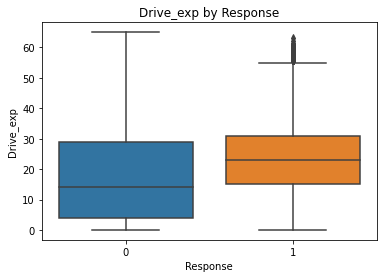

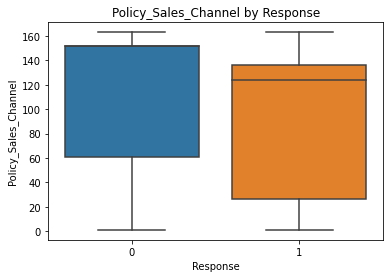

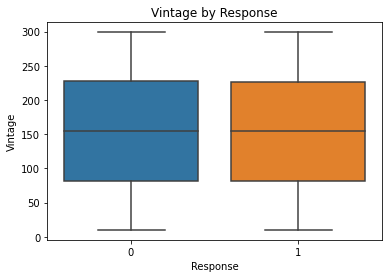

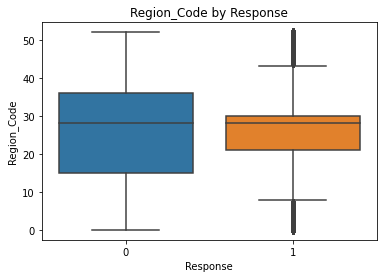

In [5]:
## distribution and checking for outliers in numeric features

features = train[['Drive_exp', 'Policy_Sales_Channel', 'Vintage', 'Region_Code']].columns

for i in features:
    sns.boxplot(x="Response",y=i,data=train)
    plt.title(i+" by "+"Response")
    plt.show()

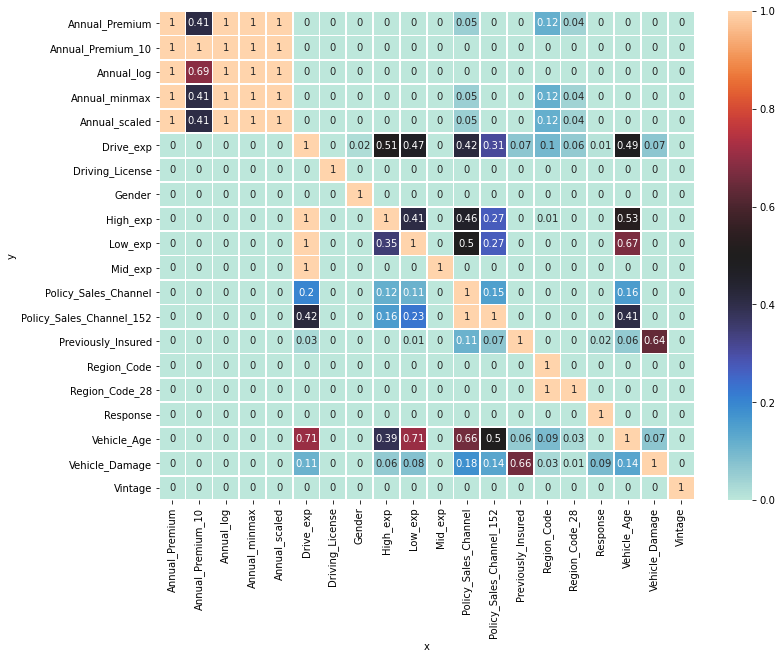

In [8]:
## PPS matrix of correlation of non-linear relations between features

matrix_pps = pps.matrix(train.drop('id', axis=1))[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_pps = matrix_pps.apply(lambda x: round(x, 2))
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matrix_pps, vmin=0, vmax=1, cmap="icefire", linewidths=0.75, annot=True)

<Figure size 432x342 with 0 Axes>

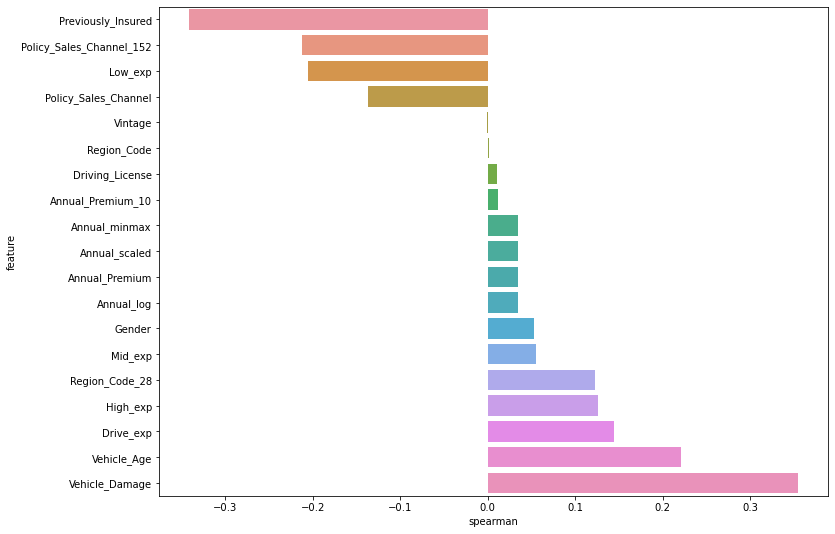

In [10]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Response'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    f, ax = plt.subplots(figsize=(12, 9))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = train.drop(['Response', 'id'], axis = 1).columns
spearman(train, features)





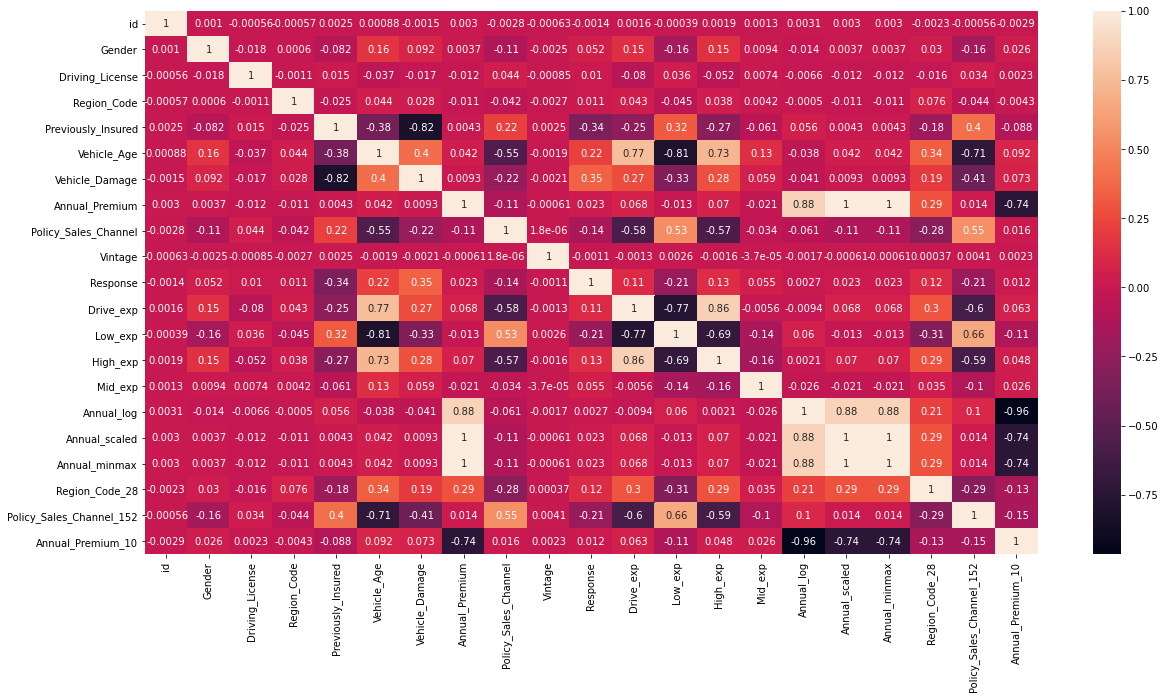

In [11]:
corrMatrix = train.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corrMatrix, annot = True)
plt.show()


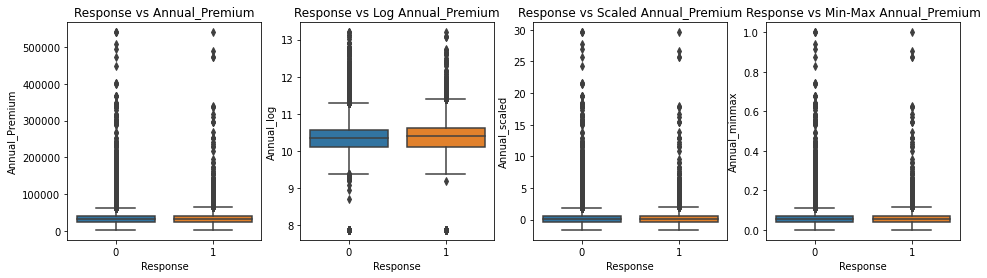

In [12]:
# Let's explore the Annual Premium by Response and see the distribuition of Amount transactions
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="Response",y="Annual_Premium",data=train, ax = axs[0])
axs[0].set_title("Response vs Annual_Premium")

sns.boxplot(x ="Response",y="Annual_log",data=train, ax = axs[1])
axs[1].set_title("Response vs Log Annual_Premium")

sns.boxplot(x ="Response",y="Annual_scaled",data=train, ax = axs[2])
axs[2].set_title("Response vs Scaled Annual_Premium")

sns.boxplot(x ="Response",y="Annual_minmax",data=train, ax = axs[3])
axs[3].set_title("Response vs Min-Max Annual_Premium")

plt.show()


In [13]:
## let's drop some features from dataset
train = train.drop(['Annual_Premium', 'Annual_minmax', 'Annual_log'], axis=1)
test = test.drop(['Annual_Premium', 'Annual_minmax', 'Annual_log'], axis=1)
train = train.drop('Driving_License', axis=1)
test = test.drop('Driving_License', axis=1)


In [14]:
#modelling...

X = train.drop(['Response', 'id'], axis=1)
y = train.Response
test_id = test.id.values

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_sample(X, y)

rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)

ros = RandomOverSampler(random_state=42)
X_ros, y_ros= ros.fit_resample(X, y)

adasyn = ADASYN(random_state=42)
X_ad, y_ad = adasyn.fit_resample(X, y)

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=10)
x_train, y_train= rus.fit_resample(x_train, y_train)



d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)


params = {
        'objective':'binary:hinge',
        'n_estimators': 800,
        'max_depth':2,
        'learning_rate':0.01,
        'eval_metric':'auc',
        'min_child_weight':4,
        'subsample':0.1,
        'colsample_bytree':0.6,
        'seed':29,
        'reg_lambda':2.5,
        'reg_alpha':7,
        'gamma':0.01,
        'scale_pos_weight':0,
        'nthread':-1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=5000
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=800, 
                           maximize=True, verbose_eval=10)


[16:17:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.50000	valid-auc:0.50000
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 800 rounds.
[10]	train-auc:0.50000	valid-auc:0.50000
[20]	train-auc:0.50000	valid-auc:0.50000
[30]	train-auc:0.50000	valid-auc:0.50000
[40]	train-auc:0.50000	valid-auc:0.50000
[50]	train-auc:0.50000	valid-auc:0.50000
[60]	train-auc:0.66537	valid-auc:0.66555
[70]	train-auc:0.75021	valid-auc:0.74936
[80]	train-auc:0.75121	valid-auc:0.75018
[90]	train-auc:0.75140	valid-auc:0.75042
[100]	train-auc:0.75178	valid-auc:0.750

[1810]	train-auc:0.79220	valid-auc:0.79165
[1820]	train-auc:0.79220	valid-auc:0.79164
[1830]	train-auc:0.79220	valid-auc:0.79164
[1840]	train-auc:0.79219	valid-auc:0.79165
[1850]	train-auc:0.79219	valid-auc:0.79162
[1860]	train-auc:0.79220	valid-auc:0.79164
[1870]	train-auc:0.79219	valid-auc:0.79169
[1880]	train-auc:0.79219	valid-auc:0.79167
[1890]	train-auc:0.79222	valid-auc:0.79164
[1900]	train-auc:0.79224	valid-auc:0.79170
[1910]	train-auc:0.79222	valid-auc:0.79160
[1920]	train-auc:0.79224	valid-auc:0.79162
[1930]	train-auc:0.79224	valid-auc:0.79160
[1940]	train-auc:0.79219	valid-auc:0.79157
[1950]	train-auc:0.79219	valid-auc:0.79155
[1960]	train-auc:0.79216	valid-auc:0.79158
[1970]	train-auc:0.79219	valid-auc:0.79155
[1980]	train-auc:0.79222	valid-auc:0.79165
[1990]	train-auc:0.79220	valid-auc:0.79167
[2000]	train-auc:0.79225	valid-auc:0.79169
[2010]	train-auc:0.79219	valid-auc:0.79164
[2020]	train-auc:0.79217	valid-auc:0.79163
[2030]	train-auc:0.79214	valid-auc:0.79163
[2040]	trai

[3720]	train-auc:0.79234	valid-auc:0.79175
[3730]	train-auc:0.79231	valid-auc:0.79175
[3740]	train-auc:0.79234	valid-auc:0.79176
[3750]	train-auc:0.79231	valid-auc:0.79176
[3760]	train-auc:0.79234	valid-auc:0.79178
[3770]	train-auc:0.79236	valid-auc:0.79175
[3780]	train-auc:0.79236	valid-auc:0.79177
[3790]	train-auc:0.79236	valid-auc:0.79178
[3800]	train-auc:0.79234	valid-auc:0.79176
[3810]	train-auc:0.79236	valid-auc:0.79177
[3820]	train-auc:0.79234	valid-auc:0.79179
[3830]	train-auc:0.79233	valid-auc:0.79176
[3840]	train-auc:0.79236	valid-auc:0.79177
[3850]	train-auc:0.79236	valid-auc:0.79172
[3860]	train-auc:0.79233	valid-auc:0.79175
[3870]	train-auc:0.79234	valid-auc:0.79178
[3880]	train-auc:0.79233	valid-auc:0.79177
[3890]	train-auc:0.79234	valid-auc:0.79177
[3900]	train-auc:0.79231	valid-auc:0.79175
[3910]	train-auc:0.79231	valid-auc:0.79177
[3920]	train-auc:0.79234	valid-auc:0.79177
[3930]	train-auc:0.79236	valid-auc:0.79177
[3940]	train-auc:0.79233	valid-auc:0.79178
[3950]	trai

Accuracy :0.66016
AUC : 0.79188
Precision : 0.25966
Recall : 0.96606
F1 : 0.40931


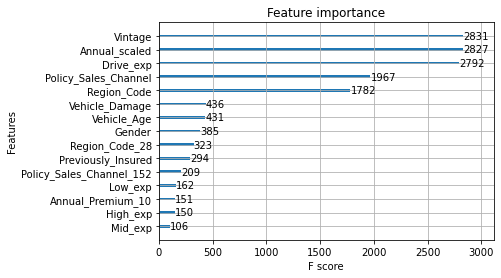

In [15]:
#Model results:

y_pred = model.predict(d_valid)
print('Accuracy :{0:0.5f}'.format(metrics.accuracy_score(y_valid, y_pred))) 
print('AUC : {0:0.5f}'.format(metrics.roc_auc_score(y_valid, y_pred)))
print('Precision : {0:0.5f}'.format(metrics.precision_score(y_valid, y_pred)))
print('Recall : {0:0.5f}'.format(metrics.recall_score(y_valid, y_pred)))
print('F1 : {0:0.5f}'.format(metrics.f1_score(y_valid, y_pred)))

confusion_matrix(y_valid, y_pred)

xgb.plot_importance(model)


Text(0.5, 0, 'False Positive Rate')

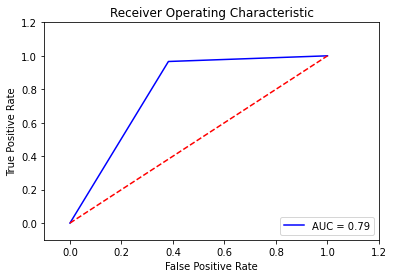

In [18]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


<Figure size 432x288 with 0 Axes>

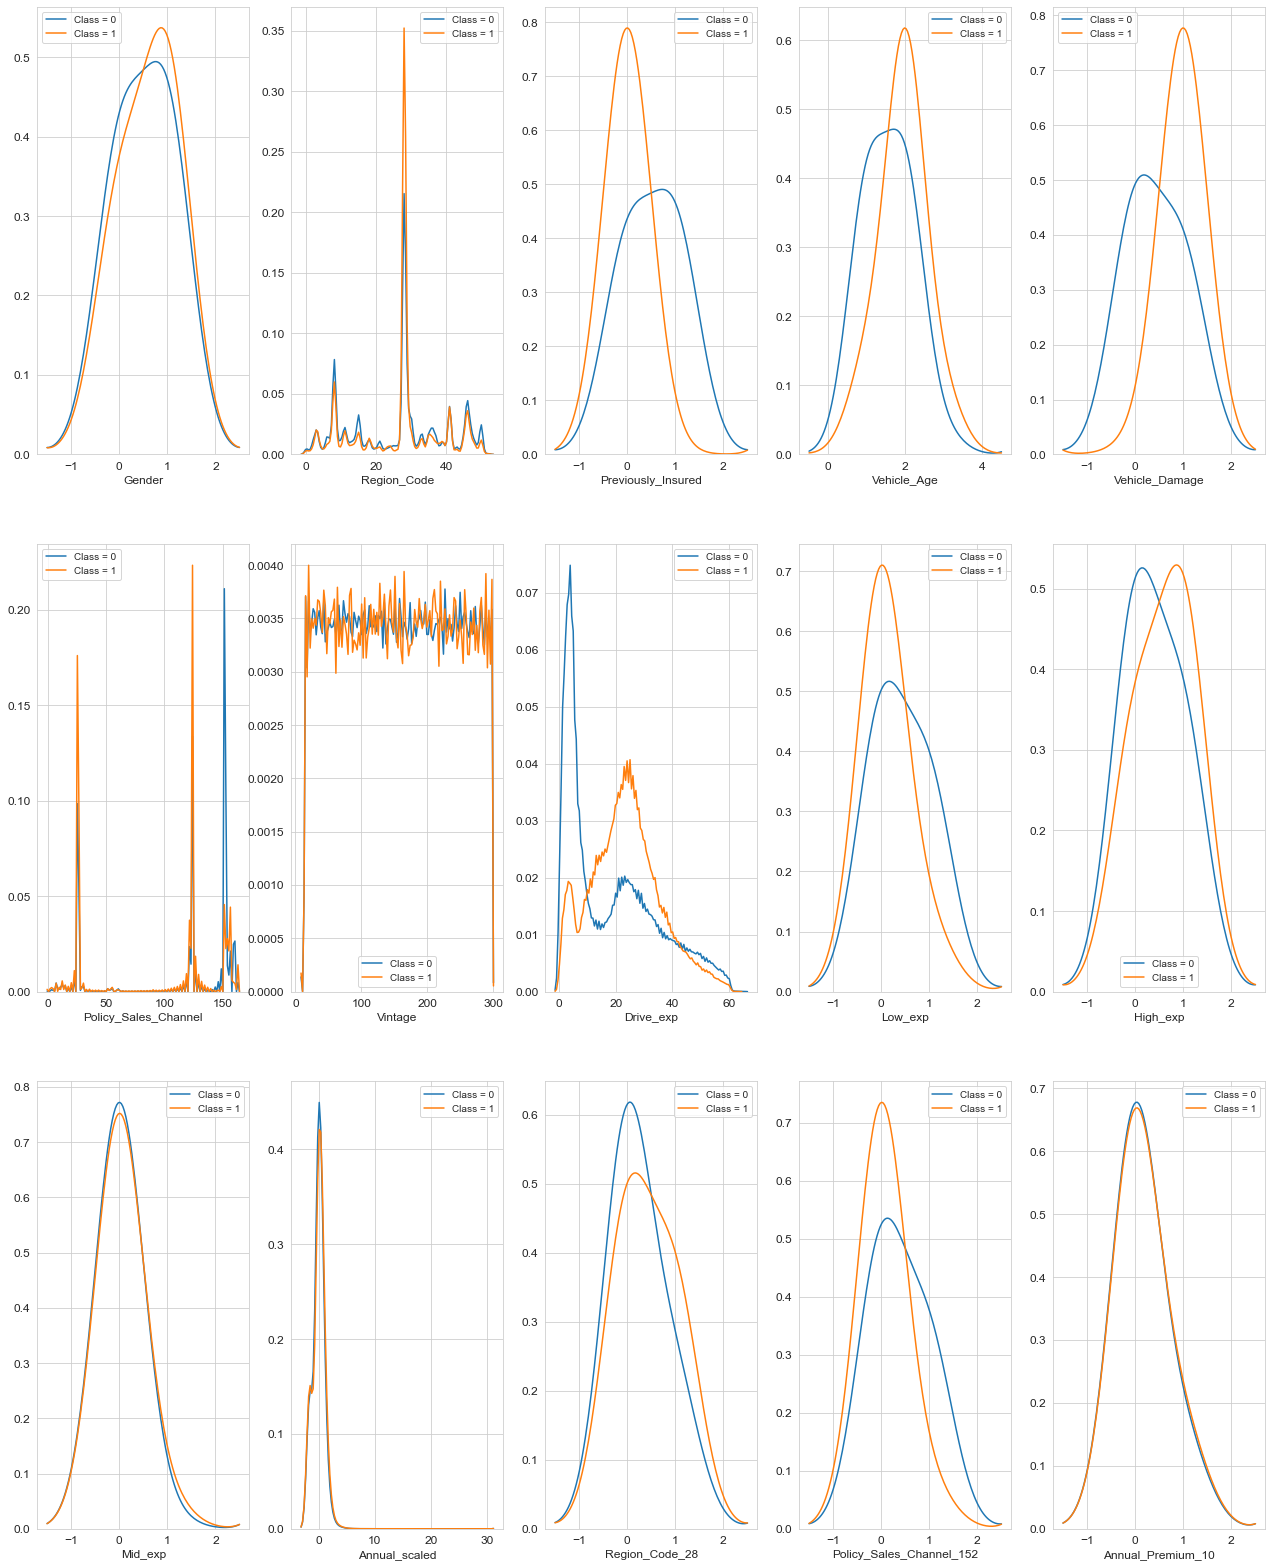

In [20]:
#some plots for some important features...

var = train.drop(['id', 'Response'], axis=1).columns.values

i = 0
t0 = train.loc[train['Response'] == 0]
t1 = train.loc[train['Response'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,5,figsize=(22,28))

for feature in var:
    i += 1
    plt.subplot(3,5,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();
